# Chunk size analysis and similarity scores

In the context of the RAG system, determining the optimal chunk size is crucial yet challenging, as there is no one-size-fits-all solution. Choosing a larger chunk size risks diluting relevant information, potentially leading to less precise similarity scores. Conversely, opting for smaller chunks may risk fragmenting crucial information, resulting in incomplete representations and potentially lower-quality responses. 


This analysis aims to explore the trade-offs involved in selecting chunk sizes and understand their impact on similarity score distributions. By acknowledging these nuances, we can strive to strike a balance between granularity and coherence in our chunking strategy, ultimately enhancing the effectiveness of the RAG system in providing accurate and informative responses to user queries.

In [104]:
# Libraries import
import os
import sys
import warnings
import subprocess
from typing import List, Dict

import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [105]:
# Modules import
sys.path.append('../') # Add parent directory to the path
from query_chatbot import load_database
from create_database import load_documents, split_text

In [106]:
# to display the plots in the notebook
%matplotlib inline
# to do not display the warnings
warnings.filterwarnings('ignore')

## Settings

Load OpenAI API key

In [107]:
load_dotenv()

True

Define series of python related questions

In [108]:
# Create a set of queries
queries_set = {
    "Qu'est ce qu'une fonction ?",
    "Quelle est la différence entre une liste et un set ?",
    "Comment itérer sur un dictionnaire ?",
    "Comment concaténer 2 chaines de caractères ?",
    "Trouve le maximum d'une liste.",
    "Comment utiliser une fonction lambda ?",
    "Dans quel cas utiliser une fonction récursive ?"
}

Define chunk sizes to be tested

In [109]:
# Create a list of sizes
sizes_db = [200, 400, 600, 800, 1000, 1500, 2000, 3000]


## Tooling

In [110]:
def create_databases(sizes_db, overlap=100, data_dir='data/markdown_processed', base_output_dir='chroma_db'):
    """
    Create databases for different chunk sizes and overlaps.

    Parameters
    ----------
    sizes_db : list
        List of chunk sizes to create databases for.
    overlap : int
        Overlap between chunks.
    data_dir : str
        Directory containing the markdown files.
    base_output_dir : str
        Base directory to save the databases.
    """
    # Define the root directory of the project
    root_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..'))
    # Define the path to the create_database.py script
    script_path = os.path.join(root_dir, 'src', 'create_database.py')
    for size in sizes_db:
        # Define the output directory for the database
        output_dir = os.path.join(root_dir, f"{base_output_dir}_{size}")
        # Construct the command to execute
        command = [
            'python', script_path,
            '--data_dir', os.path.join(root_dir, data_dir),
            '--chroma_out', output_dir,
            '--chunk_size', str(size),
            '--chunk_overlap', str(overlap)
        ]
        # print(f"Executing command: {' '.join(command)}")
        result = subprocess.run(command, capture_output=True, text=True)

        # Check if the command was successful
        if result.returncode == 0:
            print(f"Database successfully created for chunk_size={size} and chunk_overlap={overlap}\n")
        else:
            print(f"Error creating database for chunk_size={size} and chunk_overlap={overlap}")
            print(f"Error: {result.stderr}")

In [111]:
def load_all_databases(sizes_db: list[int]) -> dict[int, pd.DataFrame]:
    """
    Load all the databases for the given sizes.

    Parameters
    ----------
    sizes_db : list[int]
        List of sizes of the databases to load.
    
    Returns
    -------
    dict[int, pd.DataFrame]
        A dictionary containing the databases for each size.
    """
    databases = {}
    # Get the path of the databases
    databases_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

    for size in sizes_db:
        # Path to the database
        db_path = f"chroma_db_{size}"
        # Full path to the database
        full_path = os.path.join(databases_path, db_path)
        # load the database and store it in the dictionary
        databases[size] = load_database(full_path)

    return databases

In [112]:
# Perform similarity search with relevance scores for each database
def plot_relevance_scores_distribution(query: str, databases: dict, zoom: int = 350, save: bool = False):
    """
    Function to plot the distribution of relevance scores for each chunk size.

    Parameters
    ----------
    query : str
        The query to perform similarity search on.
    databases : dict
        A dictionary containing the databases to perform similarity search on.
    zoom : int
        The limit of the y-axis.
    save : bool
        Whether to save the plot or not.
    """
    # Create a subplot grid for each chunk size
    _fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    for i, (size, (db, initial_chunks)) in enumerate(databases.items()):
        # Perform similarity search with relevance scores
        # maximize k to be sure to get all the results
        results = db.similarity_search_with_relevance_scores(query, k=6000)

        # Extract relevance scores from tuple (document, score) structure
        scores = [score for _doc, score in results]

        # Get the separation score for the top 10 chunks
        sorted_scores = sorted(scores, reverse=True)
        separation_score = sorted_scores[9]

        # Plot histogram of relevance scores
        row = i // 4
        col = i % 4
        axes[row, col].hist(scores, bins=30, alpha=0.7, color='blue')
        axes[row, col].set_xlim(-1, 1) # Set x-axis limits
        axes[row, col].set_title(f"Chunk Size : {size}")
        axes[row, col].set_xlabel('Relevance Scores') # Add x-axis labels
        axes[row, col].set_ylabel('Frequency') # Add y-axis label
        axes[row, col].set_ylim(0, zoom) # Set y-axis limits

        # Add legend indicating the initial number of chunks
        axes[row, col].text(0.05, 0.97, f"Chunks: {initial_chunks}", transform=axes[row, col].transAxes, fontsize=12,
                            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        # Plot vertical line to separate top 10 chunks
        axes[row, col].axvline(x=separation_score, color='red', linestyle='--')

    # Add overall title for the plot
    plt.suptitle(f"{query}", y=0.96, fontsize=20)

    # Adjust vertical spacing between subplots
    plt.subplots_adjust(hspace=0.3)

    # Create the directory if it doesn't exist
    path = "../../data/chunk_size_analysis/distribution_plots"
    os.makedirs(path, exist_ok=True)

    # Save the plot as an image
    query = query.lower().replace(" ", "_")
    if save:
        file_name = f"distribution_{query}.png"
    save_path = os.path.join(path, file_name)
    plt.savefig(save_path)
    print(f"\033[92mPlot saved as {file_name}.\033[0m\n\n")

In [113]:
def plot_top10_scores_details(query: str, sizes_db: int, databases: dict) -> None:
    """
    Function to plot the top 10 relevance scores details for a given query and chunk size.

    Parameters
    ----------
    query : str
        The query to perform similarity search on.
    sizes_db : int
        The size of the database to perform similarity search on.
    databases : dict
        A dictionary containing the databases to perform similarity search on.
    """
    # Perform similarity search with relevance scores for the specified question and size
    db, _initial_chunks = databases[sizes_db]
    results = db.similarity_search_with_relevance_scores(query, k=6000)

    # Sort the results by relevance scores in descending order
    sorted_results = sorted(results, key=lambda score: score[1], reverse=True)

    # Get the top 10 most relevant chunks
    top_10_details = sorted_results[:10]

    # Extract the relevance scores and document content for the top 10 chunks
    scores = [score for _doc, score in top_10_details]
    docs = [doc.page_content for doc, _score in top_10_details]
    docs_id = [doc.metadata["id"] for doc, _score in top_10_details]

    # Adjust text for hovertext to contain paragraphs if necessary
    hover_texts = []
    for doc in docs:
        # Split text into paragraphs
        paragraphs = doc.split(".") 
        # Join paragraphs with HTML line breaks
        hover_texts.append("<br>".join(paragraphs))

    # Create bar chart
    fig = go.Figure()

    # Add bar trace
    fig.add_trace(go.Bar(
        y=[f"Chunk {doc_id}" for doc_id in docs_id],
        x=scores,
        orientation='h',
        marker=dict(
            color='rgba(0, 0, 255, 0.6)',
            line=dict(
                color='rgba(0, 0, 255, 1.0)',
                width=1)
        ),
        hoverinfo='text',
        hovertext=hover_texts,
    ))

    # Add text annotations for scores
    for i, score in enumerate(scores):
        fig.add_annotation(
            y= f"Chunk {docs_id[i]}",  # Use the document ID as y-coordinate label
            x=score,
            text=f"<b>{score:.2f}</b>",
            showarrow=False,
        )

    # Update layout
    fig.update_layout(
        title="Top 10 chunks with highest relevance scores",
        xaxis_title="Relevance Score",
        yaxis_title="Chunks",
        margin=dict(l=150, r=20, t=70, b=70),
        hoverlabel=dict(font=dict(size=10), bgcolor='lightgrey'),
    )

    # Add question and chunk size just below the title
    fig.add_annotation(
        text=f"Question: {query}<br>Chunk Size: {sizes_db}",
        align='left',
        showarrow=False,
        xref='paper',
        yref='paper',
        x=0.06,
        y=0.99,  # Adjust vertical position below the title
        xanchor='center',
        yanchor='bottom',
        font=dict(size=11, color="blue"),
    )

    # Show plot
    fig.show()

In [114]:
def plot_top_similarity_scores(queries_set: set, databases: list, k: int = 10) -> None:
    """
    Function to plot the top similarity scores for different queries and database sizes.

    Parameters
    ----------
    queries_set : set
        A set of queries to perform similarity search on.
    databases : list
        A list of databases to perform similarity search on.
    k : int, optional
        The number of top similarity scores to plot, by default 10.
    """

    # Define symbols and colors for each query
    symbols = ['o', 's', '^', 'd', '*', 'x', '>', 'p']  
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'gray', 'orange']

    _fig, ax = plt.subplots(figsize=(12, 8))

    for i, query in enumerate(queries_set):
        # Get results for the current query
        query_results = {}
        for size, (db, _) in databases.items():
            results = db.similarity_search_with_relevance_scores(query, k=6000)
            sorted_results = sorted(results, key=lambda score: score[1], reverse=True)
            query_results[size] = [score for _, score in sorted_results[:k]]

        # Initialize lists to store min and max scores for each query
        min_scores = []

        # Plot the similarity scores
        for j, (size, scores) in enumerate(query_results.items()):
            mini = min(scores)
            min_scores.append(mini)

            # Manually set the y positions using sizes_db
            y_positions = [sizes_db.index(size)]
            ax.scatter(mini, y_positions, color=colors[i], marker=symbols[i], label=query if j == 0 else "", alpha=0.7)
        
        ax.plot(min_scores, range(len(sizes_db)), color=colors[i], linestyle='--', alpha=0.7)

    # Set labels and title with larger font size
    ax.set_xlabel("Similarity Scores", fontsize=16)
    ax.set_ylabel("Chunk Size (character)", fontsize=16)
    ax.set_yticks(range(len(sizes_db)))
    ax.set_yticklabels(sizes_db)
    ax.set_title(f"Similarity Scores of {k} best chunk for Different Queries and Chunk Sizes", fontsize=16)

    # Add legend with larger font size
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

    plt.grid(True, 'minor')
    plt.tight_layout()
    plt.show()

In [115]:
def get_chunks_from_chapter(chapter_path: str, chunk_size: int = 1000, overlap: int = 200) -> Dict[str, List[str]]:
    # load documents from the specified directory
    documents = load_documents(chapter_path)
    chapters_details = {}
    for chapter in documents:
        chapters_details[chapter.metadata["source"].split("/")[-1].split(".")[0]] = chapter.page_content

    # Sort chapters by their keys
    chapters_details = dict(sorted(chapters_details.items()))

    # Split chapters into chunks
    chunks = {}
    for chapter, content in chapters_details.items():
        chunks[chapter] = split_text(content, chunk_size, overlap)

    return chunks


In [116]:
def calculate_similarity(chunks: List[Dict[str, str]]) -> List[float]:
    """Calculate the cosine similarity between consecutive chunks.
    
    Parameters
    ----------
    chunks : list of dict
        List of chunks where each chunk is a dictionary with keys 'page_content' and 'metadata'.
    
    Returns
    -------
    similarities : list of float
        List of cosine similarities between consecutive chunks.
    """
    # Extract text content from chunks
    texts = [chunk.page_content for chunk in chunks]
    
    # Vectorize the text using TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Calculate cosine similarities between consecutive chunks
    similarities = []
    for i in range(len(texts) - 1):
        similarity = cosine_similarity(tfidf_matrix[i], tfidf_matrix[i + 1])[0, 0]
        similarities.append(similarity)
    
    return similarities


In [117]:
def analyze_chapters(chapters: Dict[str, List[Dict[str, str]]]):
    """Analyze the similarity between consecutive chunks for each chapter and plot the results.
    
    Parameters
    ----------
    chapters : dict
        Dictionary where keys are chapter names and values are lists of chunks.

    """
    selected_chapters = ['02', '04', '06', '08', '10', '12', '13', '16', '17', '18', '19', '20']
    # keep only selected chapters in the key of the dictionary if he starts with the selected_chapters
    selected_chapter_keys = [key for key in chapters.keys() if key.startswith(tuple(selected_chapters))]

    num_chapters = len(selected_chapters)
    cols = 4
    rows = (num_chapters + cols - 1) // cols  # Calculate number of rows needed
    
    fig, axs = plt.subplots(rows, cols, figsize=(20, 6 * rows))
    
    if num_chapters == 1:
        axs = [axs]
    else:
        axs = axs.flatten()
    
    fig.suptitle(f'Similarity between consecutive chunks (n and n+1)', fontsize=16)

    for i, chapter_name in enumerate(selected_chapter_keys):
        chunks = chapters[chapter_name]
        similarities = calculate_similarity(chunks)
        axs[i].plot(range(1, len(similarities) + 1), similarities, marker='o', c="blue")
        axs[i].set_title(f'Chapter {chapter_name}', fontsize=12)
        axs[i].set_xlabel('Chunk number', fontsize=11)
        axs[i].set_ylabel('Cosine similarity', fontsize=11)
        axs[i].set_xticks(range(0, len(similarities) + 1, 5))
        axs[i].grid(True)
        axs[i].set_ylim(0, 1)

    
    # Remove any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Preprocessing

### Create databases with different chunk sizes (Optional)

In [118]:
create_databases(sizes_db)

Database successfully created for chunk_size=200 and chunk_overlap=100

Database successfully created for chunk_size=400 and chunk_overlap=100

Database successfully created for chunk_size=600 and chunk_overlap=100

Database successfully created for chunk_size=800 and chunk_overlap=100

Database successfully created for chunk_size=1000 and chunk_overlap=100

Database successfully created for chunk_size=1500 and chunk_overlap=100

Database successfully created for chunk_size=2000 and chunk_overlap=100

Database successfully created for chunk_size=3000 and chunk_overlap=100



### Load databases

In [119]:
databases = load_all_databases(sizes_db)

2024-06-27 16:30:32.972 | INFO     | query_chatbot:load_database:159 - Loading the vector database.
2024-06-27 16:30:32.995 | INFO     | query_chatbot:load_database:165 - Chunks in the database: 2859
2024-06-27 16:30:32.996 | SUCCESS  | query_chatbot:load_database:167 - Vector database prepared successfully.

2024-06-27 16:30:32.996 | INFO     | query_chatbot:load_database:159 - Loading the vector database.
2024-06-27 16:30:33.016 | INFO     | query_chatbot:load_database:165 - Chunks in the database: 1810
2024-06-27 16:30:33.016 | SUCCESS  | query_chatbot:load_database:167 - Vector database prepared successfully.

2024-06-27 16:30:33.017 | INFO     | query_chatbot:load_database:159 - Loading the vector database.
2024-06-27 16:30:33.037 | INFO     | query_chatbot:load_database:165 - Chunks in the database: 1312
2024-06-27 16:30:33.037 | SUCCESS  | query_chatbot:load_database:167 - Vector database prepared successfully.

2024-06-27 16:30:33.037 | INFO     | query_chatbot:load_database:15

## Exploring the Impact of Chunk Size on Similarity Score Distribution 📊

Number of requested results 6000 is greater than number of elements in index 2859, updating n_results = 2859
Number of requested results 6000 is greater than number of elements in index 1810, updating n_results = 1810
Number of requested results 6000 is greater than number of elements in index 1312, updating n_results = 1312
Number of requested results 6000 is greater than number of elements in index 1034, updating n_results = 1034
Number of requested results 6000 is greater than number of elements in index 857, updating n_results = 857
Number of requested results 6000 is greater than number of elements in index 654, updating n_results = 654
Number of requested results 6000 is greater than number of elements in index 544, updating n_results = 544
Number of requested results 6000 is greater than number of elements in index 459, updating n_results = 459


Plot saved as distribution_qu'est_ce_qu'une_fonction_?.png.




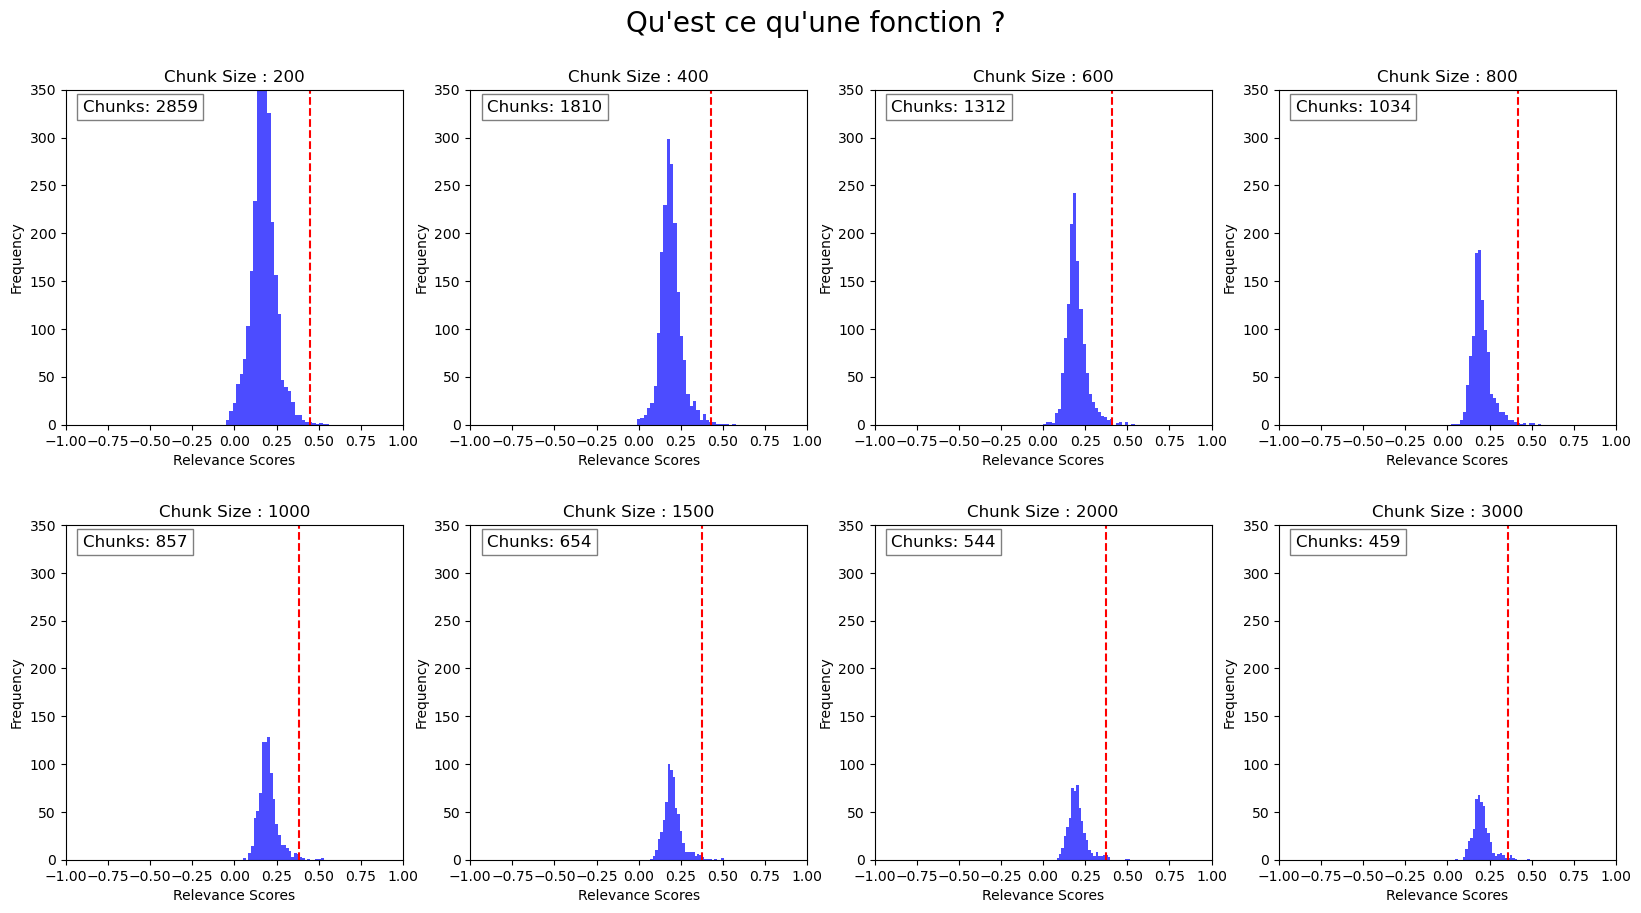

In [120]:
# Perform similarity search with relevance scores for the first query
query = queries_set.pop()
plot_relevance_scores_distribution(query, databases, zoom=350, save=True)

We can clearly observe that there is no significant difference in the distribution of similarity scores across different chunk sizes. This suggests that the choice of chunk size may not have a substantial impact on the similarity score distribution. However, it is essential to consider other factors such as the nature of the text data, the complexity of the queries, the tokens limits of the model, and the desired level of granularity when determining the optimal chunk size for a given task.

Let's take a closer look to the top 10 chunks :

Here is a plot made with Plotly to dynamically visualize the content and score of the top 10 chunks resulting from the similarity search of a query in the vector database with the size specified.

In [121]:
plot_top10_scores_details("Qu'est ce qu'une fonction ?", 200, databases)

Number of requested results 6000 is greater than number of elements in index 2859, updating n_results = 2859


## Set a cutoff threshold for similarity scores🚦

Know we want to set a cut-off to take only chunks with a pertinent context (similar enough to the query). As we see it in the distribution of the similarity scores, the threshold should be around 0.5, but we want to verify this assumption.

Here is a plot that show the similarity score of the top 3 chunks for different chunk sizes.

Number of requested results 6000 is greater than number of elements in index 2859, updating n_results = 2859
Number of requested results 6000 is greater than number of elements in index 1810, updating n_results = 1810
Number of requested results 6000 is greater than number of elements in index 1312, updating n_results = 1312
Number of requested results 6000 is greater than number of elements in index 1034, updating n_results = 1034
Number of requested results 6000 is greater than number of elements in index 857, updating n_results = 857
Number of requested results 6000 is greater than number of elements in index 654, updating n_results = 654
Number of requested results 6000 is greater than number of elements in index 544, updating n_results = 544
Number of requested results 6000 is greater than number of elements in index 459, updating n_results = 459
Number of requested results 6000 is greater than number of elements in index 2859, updating n_results = 2859
Number of requested results

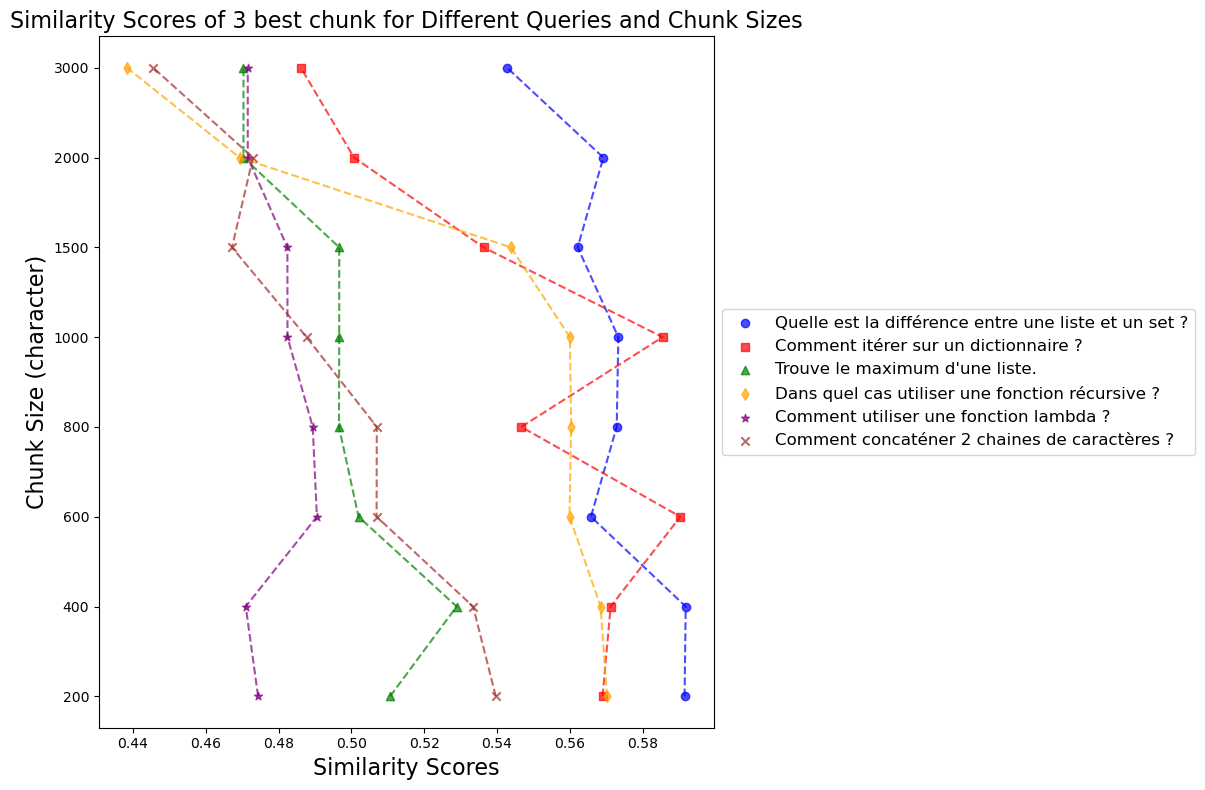

In [122]:
plot_top_similarity_scores(queries_set, databases, 3)

Number of requested results 6000 is greater than number of elements in index 2859, updating n_results = 2859
Number of requested results 6000 is greater than number of elements in index 1810, updating n_results = 1810
Number of requested results 6000 is greater than number of elements in index 1312, updating n_results = 1312
Number of requested results 6000 is greater than number of elements in index 1034, updating n_results = 1034
Number of requested results 6000 is greater than number of elements in index 857, updating n_results = 857
Number of requested results 6000 is greater than number of elements in index 654, updating n_results = 654
Number of requested results 6000 is greater than number of elements in index 544, updating n_results = 544
Number of requested results 6000 is greater than number of elements in index 459, updating n_results = 459
Number of requested results 6000 is greater than number of elements in index 2859, updating n_results = 2859
Number of requested results

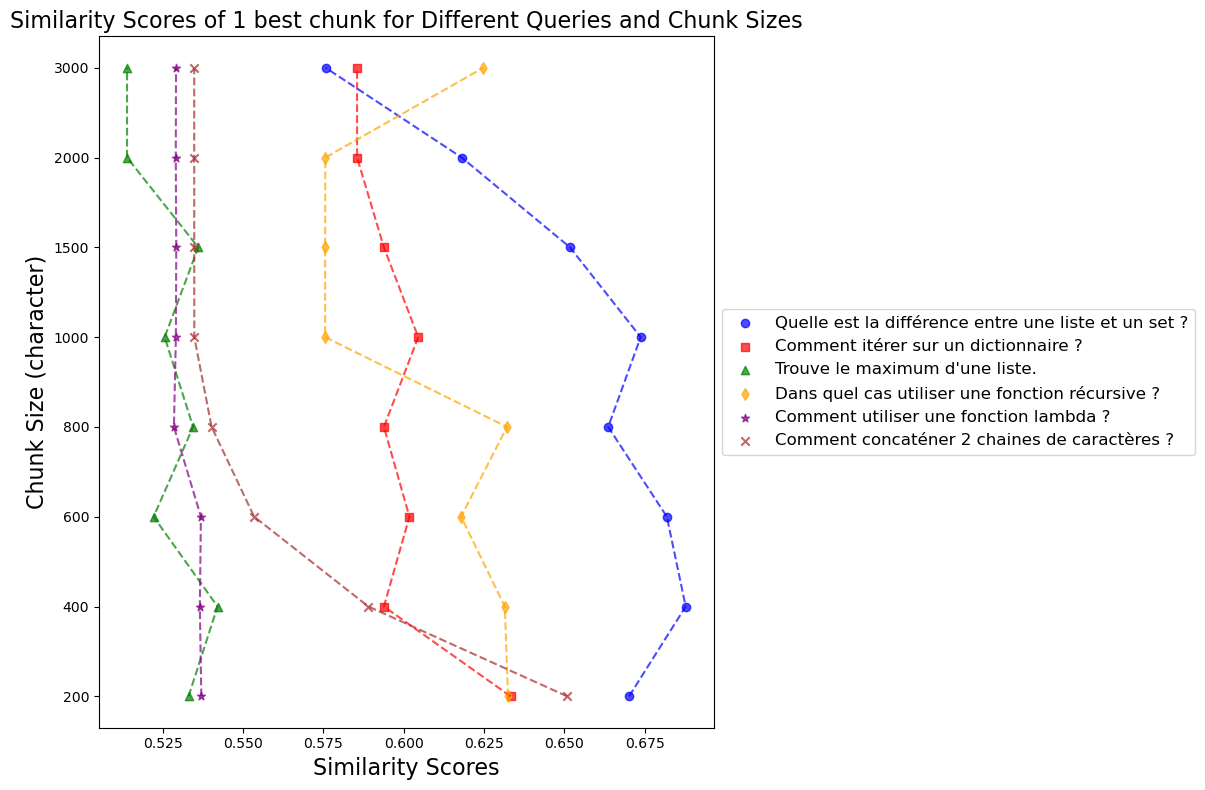

In [123]:
plot_top_similarity_scores(queries_set, databases, 1)

Now we want to study the similarity score between successive chunks. We will plot the similarity score between the first chunk and the second, the second and the third, etc. for different chunk sizes.

In [124]:
# get the chunks from the chapter
chunks = get_chunks_from_chapter(chapter_path="../../data/markdown_raw", chunk_size=1000, overlap=200)

2024-06-27 16:31:41.048 | INFO     | create_database:load_documents:161 - Loading Markdown documents...
100%|██████████| 18/18 [00:00<00:00, 9754.20it/s]
2024-06-27 16:31:41.053 | SUCCESS  | create_database:load_documents:167 - Markdown document loading complete.

2024-06-27 16:31:41.053 | INFO     | create_database:split_text:248 - Splitting the documents...
2024-06-27 16:31:41.055 | SUCCESS  | create_database:split_text:274 - Split documents into 21 chunks.

2024-06-27 16:31:41.056 | INFO     | create_database:split_text:248 - Splitting the documents...
2024-06-27 16:31:41.058 | SUCCESS  | create_database:split_text:274 - Split documents into 24 chunks.

2024-06-27 16:31:41.058 | INFO     | create_database:split_text:248 - Splitting the documents...
2024-06-27 16:31:41.061 | SUCCESS  | create_database:split_text:274 - Split documents into 36 chunks.

2024-06-27 16:31:41.061 | INFO     | create_database:split_text:248 - Splitting the documents...
2024-06-27 16:31:41.063 | SUCCESS  | c

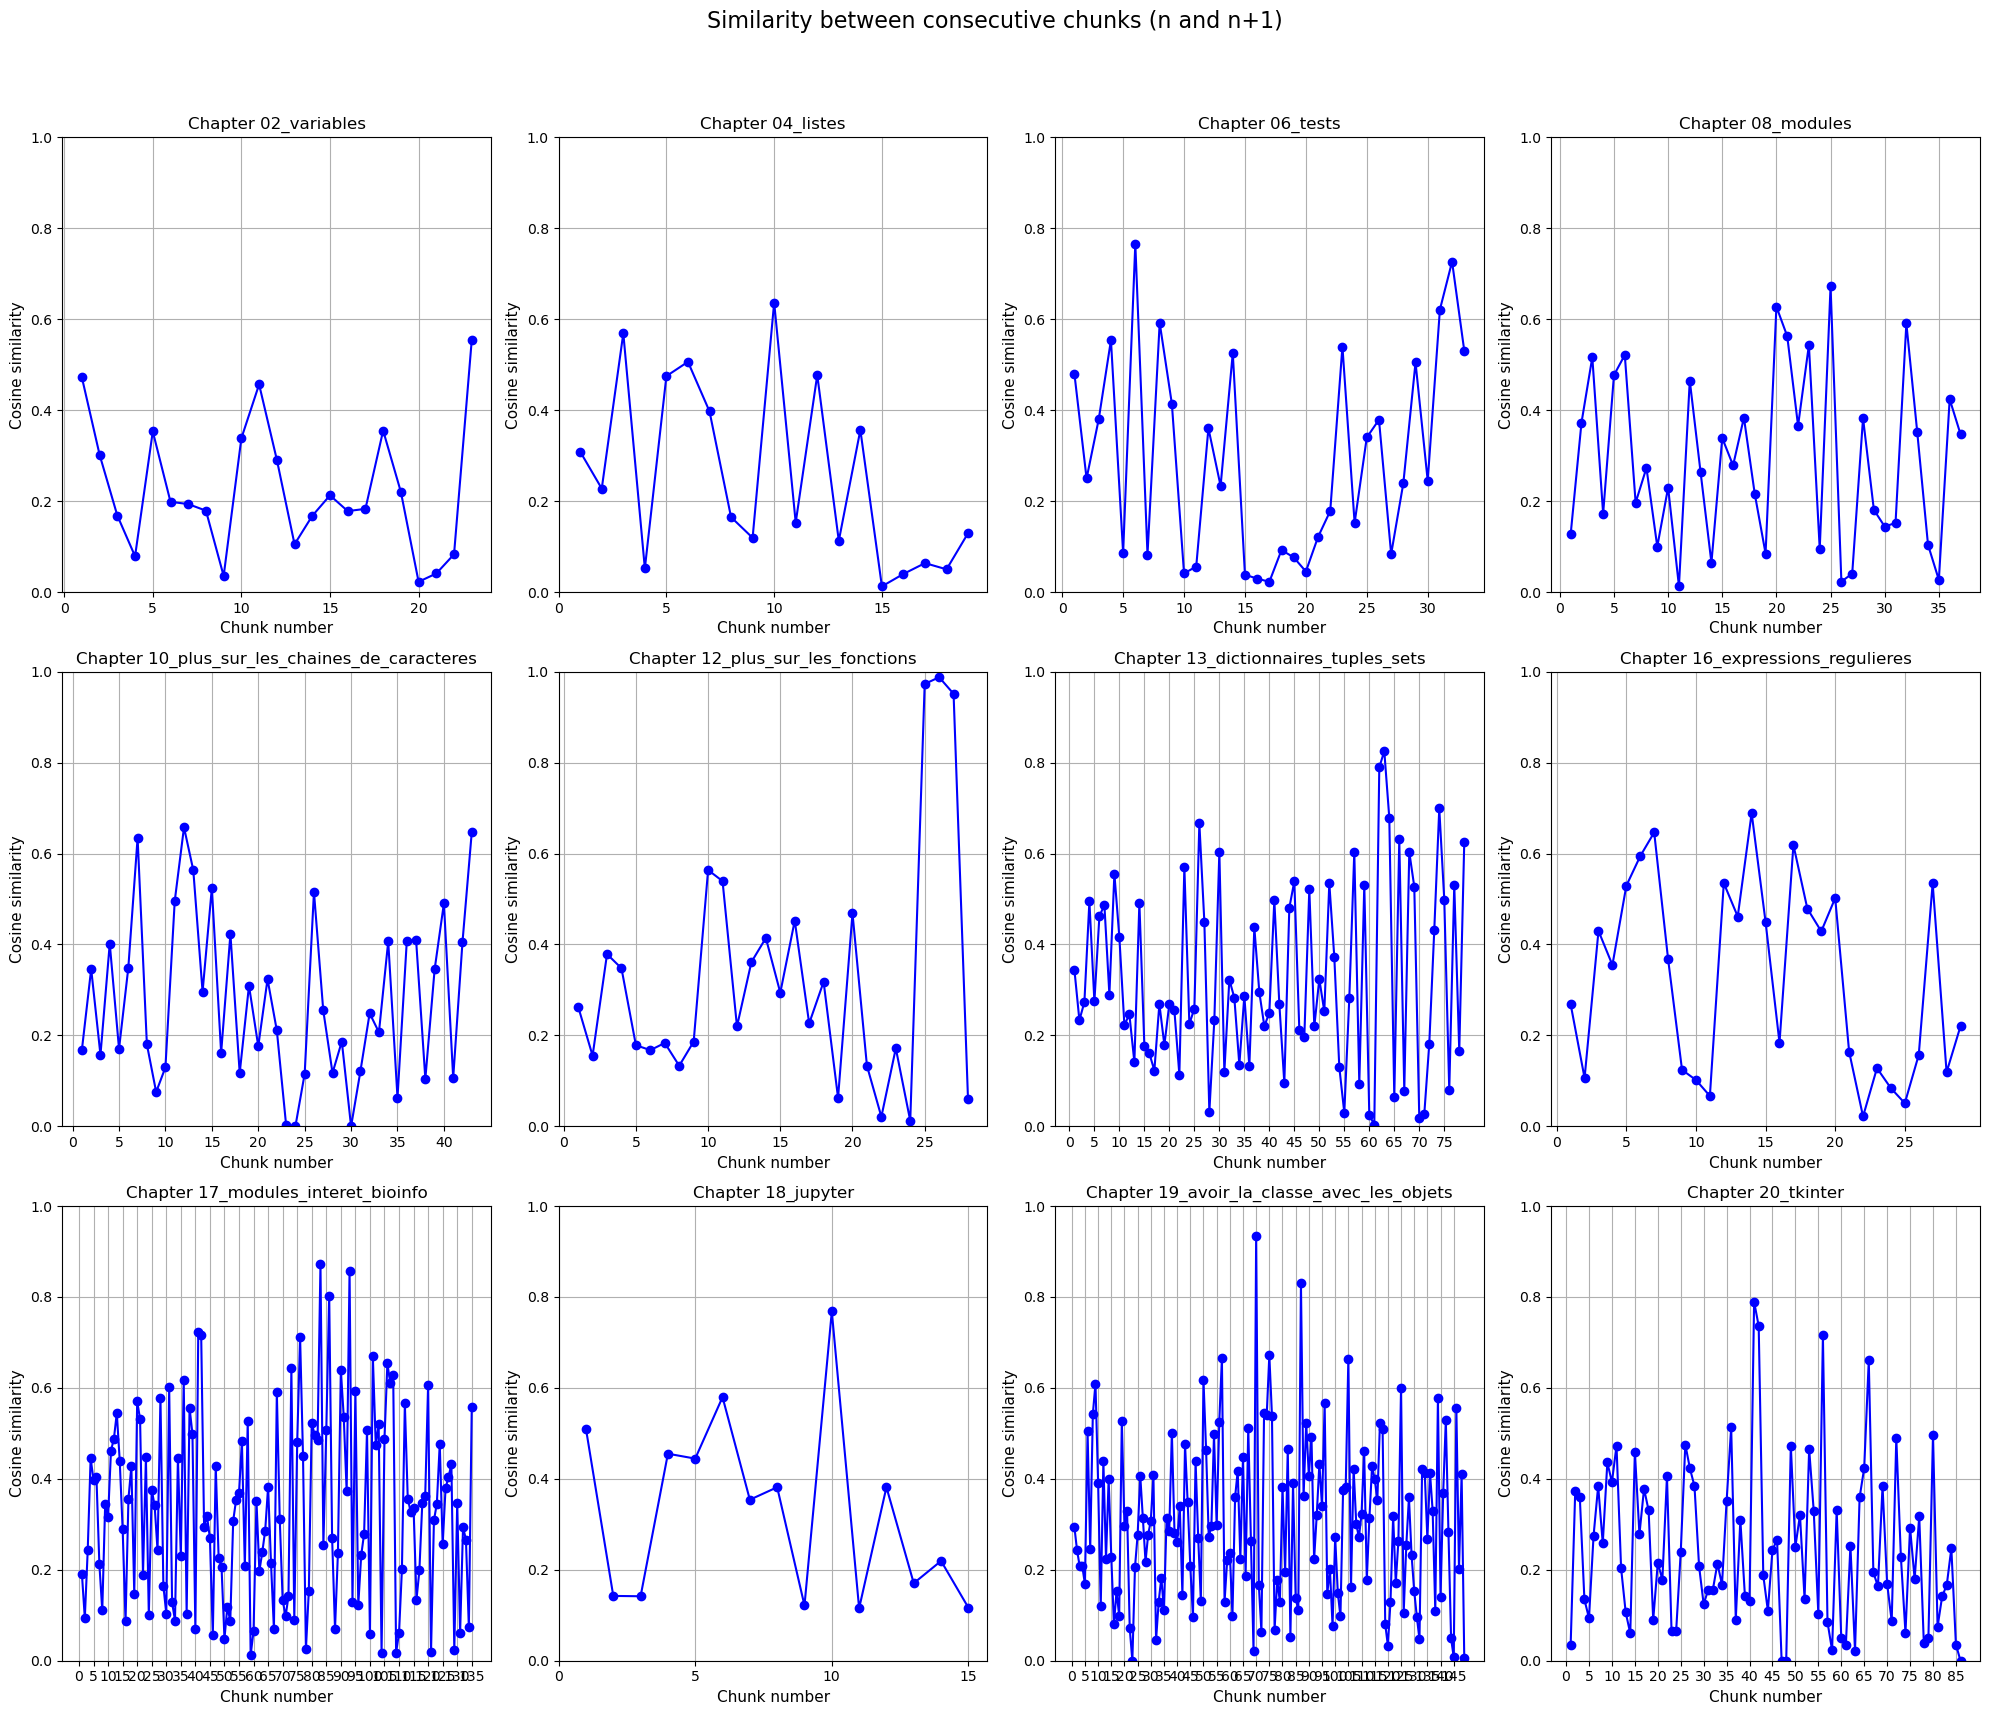

In [125]:
# analyze the similarity between consecutive chunks for each chapter
analyze_chapters(chunks)

## Package versions

In [127]:
## Package versions
%load_ext watermark
# Python implementation and version, and machine architecture
%watermark
# Versions for jupyterlab, imported packages and watermark itself
%watermark --packages jupyterlab,openai,matplotlib,plotly,sklearn,dotenv,pandas --iversions --watermark
# Name of conda environment
%watermark --conda

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-06-27T16:33:11.231319+02:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.25.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 6.5.0-41-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 6
Architecture: 64bit

jupyterlab: 4.0.11
openai    : 1.35.3
matplotlib: 3.8.4
plotly    : 5.22.0
sklearn   : 1.4.2
dotenv    : unknown
pandas    : 2.2.2

sys            : 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]
pandas         : 2.2.2
matplotlib     : 3.8.4
create_database: 1.0.0
plotly         : 5.22.0

Watermark: 2.4.3

conda environment: biopyassistant-sandbox-env

